In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

In [48]:
df = pd.read_csv('/home/darshan39/code-for-darshan/Pytorch-Learning-For-Me/archive/coaster_db.csv')
df.shape

(1087, 56)

In [49]:
df.head()

,coaster_name,Length,Speed,Location,Status,Opening date,Type,Manufacturer,Height restriction,Model,Height,Inversions,Lift/launch system,Cost,Trains,Park section,Duration,Capacity,G-force,Designer,Max vertical angle,Drop,Soft opening date,Fast Lane available,Replaced,Track layout,Fastrack available,Soft opening date.1,Closing date,Opened,Replaced by,Website,Flash Pass Available,Must transfer from wheelchair,Theme,Single rider line available,Restraint Style,Flash Pass available,Acceleration,Restraints,Name,year_introduced,latitude,longitude,Type_Main,opening_date_clean,speed1,speed2,speed1_value,speed1_unit,speed_mph,height_value,height_unit,height_ft,Inversions_clean,Gforce_clean
0,Switchback Railway,600 ft (180 m),6 mph (9.7 km/h),Coney Island,Removed,"June 16, 1884",Wood,LaMarcus Adna Thompson,NaN,Lift Packed,50 ft (15 m),NaN,gravity,NaN,NaN,Coney Island Cyclone Site,1:00,1600 riders per hour,2.9,LaMarcus Adna Thompson,30°,43 ft (13 m),NaN,NaN,NaN,Gravity pulled coaster,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1884,40.5740,-73.9780,Wood,1884-06-16,6 mph,9.7 km/h,6.0,mph,6.0,50.0,ft,NaN,0,2.9
1,Flip Flap Railway,NaN,NaN,Sea Lion Park,Removed,1895,Wood,Lina Beecher,NaN,NaN,NaN,1.0,NaN,NaN,a single car. Riders are arranged 1 across in ...,NaN,NaN,NaN,12,Lina Beecher,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1895,40.5780,-73.9790,Wood,1895-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,12.0
2,Switchback Railway (Euclid Beach Park),NaN,NaN,"Cleveland, Ohio, United States",Closed,NaN,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1896,41.5800,-81.5700,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,Loop the Loop (Coney Island),NaN,NaN,Other,Removed,1901,Steel,Edwin Prescott,NaN,NaN,NaN,1.0,NaN,NaN,a single car. Riders are arranged 2 across in ...,NaN,NaN,NaN,NaN,Edward A. Green,NaN,NaN,NaN,NaN,Switchback Railway,NaN,NaN,NaN,1910,NaN,Giant Racer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1901,40.5745,-73.9780,Steel,1901-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
4,Loop the Loop (Young's Pier),NaN,NaN,Other,Removed,1901,Steel,Edwin Prescott,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Edward A. Green,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1901,39.3538,-74.4342,Steel,1901-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN


In [50]:
df.columns

Index(['coaster_name', 'Length', 'Speed', 'Location', 'Status', 'Opening date',
       'Type', 'Manufacturer', 'Height restriction', 'Model', 'Height',
       'Inversions', 'Lift/launch system', 'Cost', 'Trains', 'Park section',
       'Duration', 'Capacity', 'G-force', 'Designer', 'Max vertical angle',
       'Drop', 'Soft opening date', 'Fast Lane available', 'Replaced',
       'Track layout', 'Fastrack available', 'Soft opening date.1',
       'Closing date', 'Opened', 'Replaced by', 'Website',
       'Flash Pass Available', 'Must transfer from wheelchair', 'Theme',
       'Single rider line available', 'Restraint Style',
       'Flash Pass available', 'Acceleration', 'Restraints', 'Name',
       'year_introduced', 'latitude', 'longitude', 'Type_Main',
       'opening_date_clean', 'speed1', 'speed2', 'speed1_value', 'speed1_unit',
       'speed_mph', 'height_value', 'height_unit', 'height_ft',
       'Inversions_clean', 'Gforce_clean'],
      dtype='object')

In [51]:
df.dtypes

coaster_name                      object
Length                            object
Speed                             object
Location                          object
Status                            object
Opening date                      object
Type                              object
Manufacturer                      object
Height restriction                object
Model                             object
Height                            object
Inversions                       float64
Lift/launch system                object
Cost                              object
Trains                            object
Park section                      object
Duration                          object
Capacity                          object
G-force                           object
Designer                          object
Max vertical angle                object
Drop                              object
Soft opening date                 object
Fast Lane available               object
Replaced        

In [52]:
df.describe()

,Inversions,year_introduced,latitude,longitude,speed1_value,speed_mph,height_value,height_ft,Inversions_clean,Gforce_clean
count,932.000000,1087.000000,812.000000,812.000000,937.000000,937.000000,965.000000,171.000000,1087.000000,362.000000
mean,1.547210,1994.986201,38.373484,-41.595373,53.850374,48.617289,89.575171,101.996491,1.326587,3.824006
std,2.114073,23.475248,15.516596,72.285227,23.385518,16.678031,136.246444,67.329092,2.030854,0.989998
min,0.000000,1884.000000,-48.261700,-123.035700,5.000000,5.000000,4.000000,13.100000,0.000000,0.800000
25%,0.000000,1989.000000,35.031050,-84.552200,40.000000,37.300000,44.000000,51.800000,0.000000,3.400000
50%,0.000000,2000.000000,40.289800,-76.653600,50.000000,49.700000,79.000000,91.200000,0.000000,4.000000
75%,3.000000,2010.000000,44.799600,2.778100,63.000000,58.000000,113.000000,131.200000,2.000000,4.500000
max,14.000000,2022.000000,63.230900,153.426500,240.000000,149.100000,3937.000000,377.300000,14.000000,12.000000


In [53]:
df1 = df[['coaster_name', 
        #'Length', 'Speed', 
        'Location', 'Status', 
        'Opening date',
       #'Type', 
       'Manufacturer', 
       #'Height restriction', 'Model', 'Height',
       #'Inversions', 'Lift/launch system', 'Cost', 'Trains', 'Park section',
       #'Duration', 'Capacity', 'G-force', 'Designer', 'Max vertical angle',
       #'Drop', 'Soft opening date', 'Fast Lane available', 'Replaced',
       #'Track layout', 'Fastrack available', 'Soft opening date.1',
       #'Closing date', 'Opened', 'Replaced by', 'Website',
       #'Flash Pass Available', 'Must transfer from wheelchair', 'Theme',
       #'Single rider line available', 'Restraint Style',
       #'Flash Pass available', 'Acceleration', 'Restraints', 'Name',
       'year_introduced', 'latitude', 'longitude', 'Type_Main',
       #'opening_date_clean', 
       #'speed1', 'speed2', 'speed1_value', 'speed1_unit',
       'speed_mph', 
       #'height_value', 'height_unit', 
       'height_ft',
       'Inversions_clean', 'Gforce_clean']].copy()

In [54]:
df.shape

(1087, 56)

In [55]:
df1 = df1.rename(columns={'coaster_name' : 'Coaster_Name',
                          'year_introduced' : 'Year_Introduced',
                          'latitude' : 'Latitude', 
                          'longitude' : 'Longitude',
                          'opening_date_clean' : 'Opening_Date_Clean',
                          'speed_mph' : 'Speed_MPH',
                          'height_ft' : 'Height_ft',
                          'Inversions_clean' : 'Inversions_Clean',
                          'Gforce_clean': 'Gforce_Clean' 
                          })

In [56]:
df1.head()

,Coaster_Name,Location,Status,Opening date,Manufacturer,Year_Introduced,Latitude,Longitude,Type_Main,Speed_MPH,Height_ft,Inversions_Clean,Gforce_Clean
0,Switchback Railway,Coney Island,Removed,"June 16, 1884",LaMarcus Adna Thompson,1884,40.5740,-73.9780,Wood,6.0,NaN,0,2.9
1,Flip Flap Railway,Sea Lion Park,Removed,1895,Lina Beecher,1895,40.5780,-73.9790,Wood,NaN,NaN,1,12.0
2,Switchback Railway (Euclid Beach Park),"Cleveland, Ohio, United States",Closed,NaN,NaN,1896,41.5800,-81.5700,Other,NaN,NaN,0,NaN
3,Loop the Loop (Coney Island),Other,Removed,1901,Edwin Prescott,1901,40.5745,-73.9780,Steel,NaN,NaN,1,NaN
4,Loop the Loop (Young's Pier),Other,Removed,1901,Edwin Prescott,1901,39.3538,-74.4342,Steel,NaN,NaN,1,NaN


In [57]:
df1.isna().sum()

Coaster_Name          0
Location              0
Status              213
Opening date        250
Manufacturer         59
Year_Introduced       0
Latitude            275
Longitude           275
Type_Main             0
Speed_MPH           150
Height_ft           916
Inversions_Clean      0
Gforce_Clean        725
dtype: int64

In [58]:
df1.loc[df1.duplicated(subset='Coaster_Name')]

,Coaster_Name,Location,Status,Opening date,Manufacturer,Year_Introduced,Latitude,Longitude,Type_Main,Speed_MPH,Height_ft,Inversions_Clean,Gforce_Clean
43,Crystal Beach Cyclone,Crystal Beach Park,Removed,1926,Traver Engineering,1927,42.8617,-79.0598,Wood,60.0,NaN,0,4.0
60,Derby Racer,Revere Beach,Removed,1911,Fred W. Pearce,1937,42.4200,-70.9860,Wood,NaN,NaN,0,NaN
61,Blue Streak (Conneaut Lake),Conneaut Lake Park,Closed,"May 23, 1938",NaN,1938,41.6349,-80.3180,Wood,50.0,NaN,0,NaN
167,Big Thunder Mountain Railroad,Other,NaN,NaN,Arrow Development (California and Florida)Dyna...,1980,NaN,NaN,Steel,35.0,NaN,0,NaN
237,Thunder Run (Canada's Wonderland),Canada's Wonderland,Operating,"May 23, 1981 as Blauer Enzian, 1986 as Thunder...",Mack Rides,1986,43.8427,-79.5423,Steel,39.8,32.8,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,Lil' Devil Coaster,Six Flags Great Adventure,Operating,1999 as Road Runner Railway; 2021 as Lil' Devi...,Zamperla,2021,40.1343,-74.4434,Steel,NaN,NaN,0,NaN
1064,Little Dipper (Conneaut Lake Park),Conneaut Lake Park,Operating,1950s,Allan Herschell Company,2021,41.6343,-80.3165,Steel,NaN,NaN,0,NaN
1080,Iron Gwazi,Busch Gardens Tampa Bay,Under construction,NaN,Rocky Mountain Construction,2022,28.0339,-82.4231,Steel,76.0,NaN,2,NaN
1082,American Dreier Looping,Other,NaN,NaN,Anton Schwarzkopf,2022,NaN,NaN,Steel,53.0,NaN,3,4.7


In [59]:
df1.query('Coaster_Name == "Crystal Beach Cyclone"')

,Coaster_Name,Location,Status,Opening date,Manufacturer,Year_Introduced,Latitude,Longitude,Type_Main,Speed_MPH,Height_ft,Inversions_Clean,Gforce_Clean
39,Crystal Beach Cyclone,Crystal Beach Park,Removed,1926,Traver Engineering,1926,42.8617,-79.0598,Wood,60.0,NaN,0,4.0
43,Crystal Beach Cyclone,Crystal Beach Park,Removed,1926,Traver Engineering,1927,42.8617,-79.0598,Wood,60.0,NaN,0,4.0


In [60]:
df1 = df1.loc[-df1.duplicated(subset=['Coaster_Name', 'Location', 'Opening date'])] \
    .reset_index(drop=True)    

In [61]:
df1.shape

(990, 13)

In [62]:
df1['Year_Introduced'].value_counts()

Year_Introduced
1999    46
2000    45
1998    30
2001    29
2002    28
        ..
1952     1
1956     1
1961     1
1955     1
1959     1
Name: count, Length: 101, dtype: int64

Text(0, 0.5, 'Count')

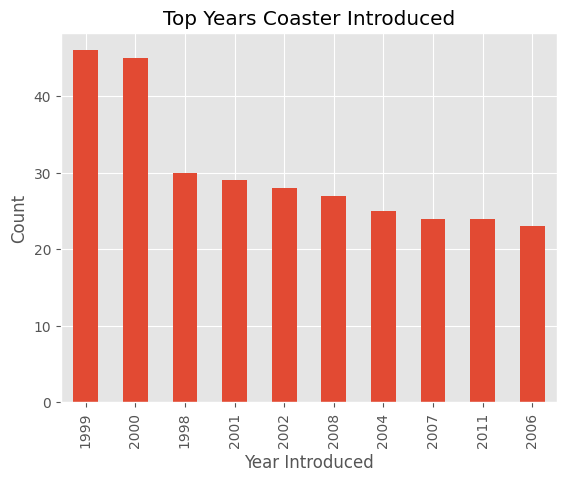

In [63]:
ax = df1['Year_Introduced'].value_counts() \
.head(10) \
.plot(kind= 'bar', title='Top Years Coaster Introduced')
ax.set_xlabel('Year Introduced')
ax.set_ylabel('Count')

<Axes: title={'center': 'Coaster Speed MPH'}, ylabel='Density'>

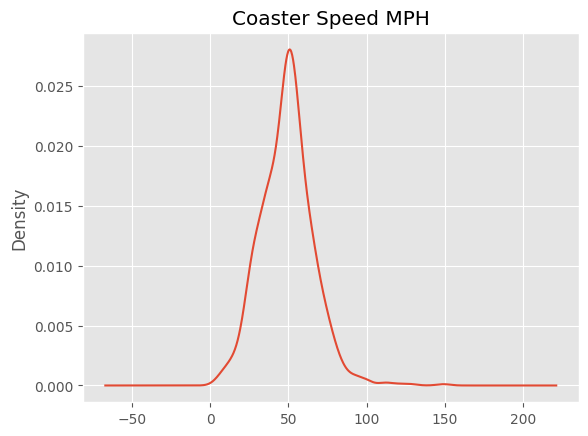

In [64]:
df1['Speed_MPH'].plot(kind='kde', xlabel='Speed MPH', ylabel='Frequency', title='Coaster Speed MPH')